<a href="https://colab.research.google.com/github/jAndrewtomich/Netflix-Data-Analysis/blob/master/netflix_data_analysis1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Dependencies, in case they are not already installed in the environment
#!pip install kaggle --upgrade -q
#!pip install numpy --upgrade -q
#!pip install opendatasets --upgrade -q
#!pip install pandas --upgrade -q
#!pip install seaborn --upgrade -q
#!pip install matplotlib --upgrade -q
#!pip install jovian --upgrade -q

In [1]:
import os
from io import StringIO # For creation of string inputs to be read as '.tsv' by pandas
import re # For separation of netflix_df.country strings into lists
import gzip # For extraction of IMDB datasets
import urllib.request
import numpy as np
import pandas as pd
import seaborn as sns
import ipywidgets as widgets
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

## Data Preparation and Cleaning

### We will download and combine all datasets necessary to our investigation.

In [2]:
os.environ['KAGGLE_USERNAME'] = "xxxx"
os.environ['KAGGLE_KEY'] = "xxxx"

In [3]:
import kaggle
kaggle.api.authenticate()
kaggle.api.dataset_download_files('shivamb/netflix-shows', path=os.getcwd(), unzip=True)

In [4]:
# The 'shivamb/netflix-shows' dataset should have downloaded and been extracted to expose file: 'netflix_titles.csv'
os.listdir()

['.config', 'netflix_titles.csv', 'sample_data']

In [5]:
netflix_df_raw = pd.read_csv('netflix_titles.csv')
netflix_df = netflix_df_raw.copy()

In [6]:
netflix_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6234 entries, 0 to 6233
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       6234 non-null   int64 
 1   type          6234 non-null   object
 2   title         6234 non-null   object
 3   director      4265 non-null   object
 4   cast          5664 non-null   object
 5   country       5758 non-null   object
 6   date_added    6223 non-null   object
 7   release_year  6234 non-null   int64 
 8   rating        6224 non-null   object
 9   duration      6234 non-null   object
 10  listed_in     6234 non-null   object
 11  description   6234 non-null   object
dtypes: int64(2), object(10)
memory usage: 584.6+ KB


In [7]:
netflix_df.shape

(6234, 12)

### The Netflix download does not include any information on viewers' ratings; the 'rating' column in the above info refers to MPAA rating.  We can get users' rating info from IMDB.  They make their data available at https://datasets.imdbws.com.

In [8]:
#Download IMDB files from official repository
urllib.request.urlretrieve('https://datasets.imdbws.com/title.ratings.tsv.gz', 'title.ratings.tsv.gz');
urllib.request.urlretrieve('https://datasets.imdbws.com/title.basics.tsv.gz', 'title.basics.tsv.gz');

#extract files as text
with gzip.open('title.ratings.tsv.gz', 'rt', encoding='utf8') as reader:
    ratings_contents = reader.read()

with gzip.open('title.basics.tsv.gz', 'rt', encoding='utf8') as reader:
    basics_contents = reader.read()
    
# Create text strings to be loaded into panda.read_csv as a tab separated file
ratings_data = StringIO(ratings_contents)
basics_data = StringIO(basics_contents)

# Create pandas dataframe from tab separated file for ratings
imdb_ratings_df_raw = pd.read_csv(ratings_data, sep='\t')
imdb_ratings_df = imdb_ratings_df_raw.copy()

# Create pandas dataframe from tab separated file for titles
imdb_titles_df_raw = pd.read_csv(basics_data, sep='\t')
imdb_titles_df = imdb_titles_df_raw.copy()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Since the IMDB database is so vast, it comes in multiple files.  I only grabbed the two that I need to make a connection to the Netflix data: 'title.ratings.tsv' and 'title.basics.tsv'.  The tables are linked with a shared key, 'tconst', used to correctly join the data.  The following table includes all titles with any associated ratings from the entire IMDB database.

In [9]:
# inner join btw the two IMDB dataframes
imdb_combo_df = pd.merge(imdb_titles_df, imdb_ratings_df, on='tconst')
imdb_combo_df

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",5.6,1663
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short",6.1,204
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance",6.5,1376
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short",6.2,123
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short",6.2,2166
...,...,...,...,...,...,...,...,...,...,...,...
1092592,tt9916580,tvEpisode,Horrid Henry Horrid Boy?,Horrid Henry Horrid Boy?,0,2012,\N,10,"Animation,Comedy,Family",7.2,5
1092593,tt9916690,tvEpisode,Horrid Henry Delivers the Milk,Horrid Henry Delivers the Milk,0,2012,\N,\N,"Animation,Comedy,Family",6.6,5
1092594,tt9916720,short,The Nun 2,The Nun 2,0,2019,\N,10,"Comedy,Horror,Mystery",6.0,66
1092595,tt9916766,tvEpisode,Episode #10.15,Episode #10.15,0,2019,\N,43,"Family,Reality-TV",6.9,15


### We'll save our IMDB dataset as a '.csv' file in case it comes in handy.

In [10]:
imdb_combo_df.to_csv('imdb_combo.csv')

In [11]:
imdb_combo_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1092597 entries, 0 to 1092596
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   tconst          1092597 non-null  object 
 1   titleType       1092597 non-null  object 
 2   primaryTitle    1092597 non-null  object 
 3   originalTitle   1092597 non-null  object 
 4   isAdult         1092597 non-null  int64  
 5   startYear       1092597 non-null  object 
 6   endYear         1092597 non-null  object 
 7   runtimeMinutes  1092597 non-null  object 
 8   genres          1092595 non-null  object 
 9   averageRating   1092597 non-null  float64
 10  numVotes        1092597 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 100.0+ MB


### Now we want just the titles listed in the Kaggle Netflix dataset which also have rating information on IMDB.

In [12]:
#Join the two datasets with the intention of having only the titles on netflix remain, but include their information from IMDB
final_df_raw = pd.merge(netflix_df, imdb_combo_df, left_on='title', right_on='primaryTitle')
final_df = final_df_raw.copy()

In [13]:
temp = final_df.groupby('cast')['genres'].apply(','.join).reset_index()
final_df.sort_values('cast').genres = temp.genres

### We have some duplicate descriptions because of alternate language versions of some titles, for instance...

In [14]:
netflix_df[netflix_df.title.str.contains('Solo: A Star Wars Story')]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
3184,80220814,Movie,Solo: A Star Wars Story,Ron Howard,"Alden Ehrenreich, Woody Harrelson, Emilia Clar...",United States,"January 9, 2019",2018,PG-13,135 min,"Action & Adventure, Children & Family Movies, ...",A young Han Solo tries to settle an old score ...
3185,81046962,Movie,Solo: A Star Wars Story (Spanish Version),Ron Howard,"Alden Ehrenreich, Woody Harrelson, Emilia Clar...",United States,"January 9, 2019",2018,PG-13,135 min,"Action & Adventure, Children & Family Movies, ...",A young Han Solo tries to settle an old score ...


In [15]:
print(netflix_df.description.iloc[3184] == netflix_df.description.iloc[3185])

True


In [16]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18699 entries, 0 to 18698
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   show_id         18699 non-null  int64  
 1   type            18699 non-null  object 
 2   title           18699 non-null  object 
 3   director        12745 non-null  object 
 4   cast            17448 non-null  object 
 5   country         17581 non-null  object 
 6   date_added      18641 non-null  object 
 7   release_year    18699 non-null  int64  
 8   rating          18692 non-null  object 
 9   duration        18699 non-null  object 
 10  listed_in       18699 non-null  object 
 11  description     18699 non-null  object 
 12  tconst          18699 non-null  object 
 13  titleType       18699 non-null  object 
 14  primaryTitle    18699 non-null  object 
 15  originalTitle   18699 non-null  object 
 16  isAdult         18699 non-null  int64  
 17  startYear       18699 non-null 

In [17]:
final_df.isnull().sum()

show_id              0
type                 0
title                0
director          5954
cast              1251
country           1118
date_added          58
release_year         0
rating               7
duration             0
listed_in            0
description          0
tconst               0
titleType            0
primaryTitle         0
originalTitle        0
isAdult              0
startYear            0
endYear              0
runtimeMinutes       0
genres               0
averageRating        0
numVotes             0
dtype: int64

### A few titles had 'NaN' for 'date_added'; notably, the TV show 'Friends'.  Since Friends was such a popular show, I wanted to find a way to include them in the table so I separated them with a dummy date of January 1, 2001.  I also changed 'NaN' values in the 'country' and 'director' columns to the python String 'Unknown' for grouping and comparison purposes; 'NaN' will not evaluate correctly.

In [18]:
final_df.country = final_df.country.fillna('Unknown')
final_df.director = final_df.director.fillna('Unknown')
final_df.date_added = final_df.date_added.fillna('January 1, 2001')

In [19]:
print(final_df.title.duplicated().sum())
print(final_df.description.duplicated().sum())
print(final_df.cast.duplicated().sum())

13836
13776
14310


### Hmm, a number of titles seem to be duplicates...  But we know it is the case that more than one movie can share a title...
### We will group the dataframe on 'cast' because there is little chance of accidentally grouping entries together since the 'cast' string, like the 'description' string, is so specific and less likely to appear in multiple entries than, say, 'title'.

In [20]:
final_df = final_df.groupby('cast').agg({'title':'max', 'type':'max', 'director':'max', 'country':'max', 'date_added':'max', 'description':'max', 'averageRating':'mean', 'numVotes':'sum','genres':'max','listed_in':'max'}).reset_index()

### This leaves us with 4388 original titles, all on Netflix and all with complete IMDB rating information.

In [21]:
final_df.sort_values('numVotes', ascending=False)

,cast,title,type,director,country,date_added,description,averageRating,numVotes,genres,listed_in
2459,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ellen...",Inception,Movie,Christopher Nolan,"United States, United Kingdom","January 1, 2020","In this mind-bending sci-fi thriller, a man ru...",7.471429,2032233,"Drama,Mystery,Short","Action & Adventure, Sci-Fi & Fantasy, Thrillers"
2016,"John Travolta, Samuel L. Jackson, Uma Thurman,...",Pulp Fiction,Movie,Quentin Tarantino,United States,"January 1, 2019",This stylized crime caper weaves together stor...,8.450000,1800432,"Crime,Drama","Classic Movies, Cult Movies, Dramas"
2244,"Keanu Reeves, Laurence Fishburne, Carrie-Anne ...",The Matrix,Movie,"Lilly Wachowski, Lana Wachowski",United States,"November 1, 2019",A computer hacker learns that what most people...,7.283333,1651527,"Sci-Fi,Short","Action & Adventure, Sci-Fi & Fantasy"
1176,"Elijah Wood, Ian McKellen, Liv Tyler, Viggo Mo...",The Lord of the Rings: The Return of the King,Movie,Peter Jackson,"New Zealand, United States","January 1, 2020",Aragorn is revealed as the heir to the ancient...,8.466667,1622766,"Action,Fantasy","Action & Adventure, Sci-Fi & Fantasy"
1177,"Elijah Wood, Ian McKellen, Liv Tyler, Viggo Mo...",The Lord of the Rings: The Two Towers,Movie,Peter Jackson,"New Zealand, United States","January 1, 2020",Frodo and Sam head to Mordor to destroy the On...,7.575000,1467356,Comedy,"Action & Adventure, Sci-Fi & Fantasy"
...,...,...,...,...,...,...,...,...,...,...,...
3108,"Omar Chaparro, Ana Claudia Talancón, Stephanie...",Como caído del cielo,Movie,Pepe Bojórquez,Mexico,"December 24, 2019","To earn his place in heaven, legendary Mexican...",7.200000,5,"Comedy,Short","Comedies, International Movies, Music & Musicals"
1068,"Dharmendra, Sharmila Tagore, Amitabh Bachchan,...",Chupke Chupke,Movie,Hrishikesh Mukherjee,India,"December 31, 2019",Jealous of the high regard in which his new wi...,7.000000,5,"Music,Romance,Short","Classic Movies, Comedies, International Movies"
3253,"Prakash Bare, Arun Kumar, Kulappulli Leela, Sa...",Kaviyude Osyath,Movie,Vineeth Anil,India,"July 1, 2018",When a late poet leaves behind his property to...,4.400000,5,Drama,"Dramas, International Movies"
3581,"Saikumar, Amal Unnithan, Manasa Radhakrishnan,...",Paulettante Veedu,Movie,Dileep Narayanan,India,"July 1, 2018",A wealthy businessman's miserly habits cause n...,3.200000,5,Drama,"Dramas, International Movies"


In [22]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4388 entries, 0 to 4387
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   cast           4388 non-null   object 
 1   title          4388 non-null   object 
 2   type           4388 non-null   object 
 3   director       4388 non-null   object 
 4   country        4388 non-null   object 
 5   date_added     4388 non-null   object 
 6   description    4388 non-null   object 
 7   averageRating  4388 non-null   float64
 8   numVotes       4388 non-null   int64  
 9   genres         4388 non-null   object 
 10  listed_in      4388 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 377.2+ KB


### We're going to parse the 'date_added' column into individual columns and add another column containing the number of countries each title was released to.

In [23]:
final_df.date_added = pd.to_datetime(final_df.date_added)
#final_df = final_df[final_df.date_added.isna() == False]
final_df['year_added'] = pd.DatetimeIndex(final_df.date_added).year.astype(int)
final_df['month_added'] = pd.DatetimeIndex(final_df.date_added).month.astype(int)
final_df['day_added'] = pd.DatetimeIndex(final_df.date_added).day.astype(int)


# Add a numeric column for the number of countries each title was released to
myList = []
for i in range(final_df.country.size):
    myList.append(final_df.country[i].split(','))

# Make a pandas Series from 'country' list
country = pd.Series(myList)

# Create 'country_count' column using map and lambda function involving 'country' Series
final_df['country_count'] = country.map(lambda x: len(x))

In [24]:
final_df.describe()

,averageRating,numVotes,year_added,month_added,day_added,country_count
count,4388.000000,4.388000e+03,4388.000000,4388.000000,4388.000000,4388.000000
mean,6.584984,3.687637e+04,2018.013902,6.880128,11.725387,1.249316
std,1.072853,1.148042e+05,1.375827,3.669965,10.006268,0.656931
min,1.600000,5.000000e+00,2001.000000,1.000000,1.000000,1.000000
25%,6.000000,5.460000e+02,2017.000000,3.000000,1.000000,1.000000
50%,6.750000,2.874000e+03,2018.000000,7.000000,11.000000,1.000000
75%,7.300000,1.862625e+04,2019.000000,10.000000,20.000000,1.000000
max,9.200000,2.032233e+06,2020.000000,12.000000,31.000000,7.000000


### Above are the mean, standard deviation, min, max and quartiles for numeric columns.

## Exploratory Analysis and Visualization

In [25]:
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

### Here are the number of titles available, where the countries are those with the 10 highest title amounts. 

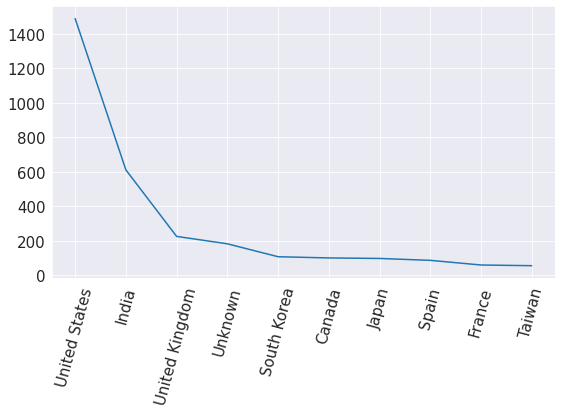

In [26]:
xplt = final_df.groupby('country').count().sort_values('title', ascending=False).reset_index().country.head(10)
yplt = final_df.groupby('country').count().sort_values('title', ascending=False).reset_index().title.head(10)
plt.xticks(rotation=75)
plt.plot(xplt, yplt)

### Let's look at the distribution of values from 'averageRating', 'year_added' and 'month_added' columns, separated into 'Movies' and 'TV Shows'.

6.3775837998580736 7.065469563869727


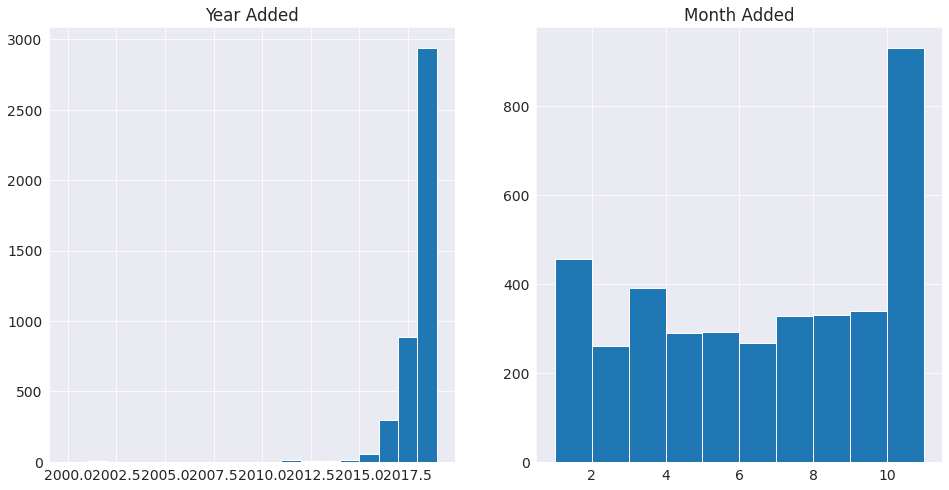

In [28]:
movie_avg = final_df[final_df.type == 'Movie'].averageRating.mean()
tv_avg = final_df[final_df.type == 'TV Show'].averageRating.mean()

print(movie_avg, tv_avg)

matplotlib.rcParams['font.size'] = 14

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].hist(final_df.year_added, bins=np.arange(2000,2020,1));
axes[0].set_title('Year Added')
axes[1].hist(final_df.month_added, bins=np.arange(1,12,1));
axes[1].set_title('Month Added')

padding=(2)

### The content 'uploaded' in 2001/2002 is the content of unkown date which i segregated as 01/01/2001.  Also, it appears that most content is added during the months of December and January; basically, at the new year.

## Here I am isolating the countries with the ultimate goal of getting a more accurate vote count.  Each individual country's totals include the vote counts for any release group that the country was included in.

In [29]:
indv_countries = final_df[final_df.country_count == 1].groupby('country')['numVotes'].sum().sort_values(ascending=False).reset_index()

In [30]:
# Creating a dictionary to hold country and vote counts; this will become our dataframe
full_votes = {}

for country in indv_countries.country:
    vote_counter = 0
    for entry in final_df.iterrows():
        if country in entry[1].country:
            vote_counter += entry[1].numVotes
    full_votes[country] = vote_counter
    
# Create a dataframe from the dictionary above
full_votes_df = pd.DataFrame.from_dict(full_votes, orient='index', columns=['total']).sort_values('total', ascending=False).reset_index()
full_votes_df = full_votes_df.rename(({'index':'country'}), axis=1)

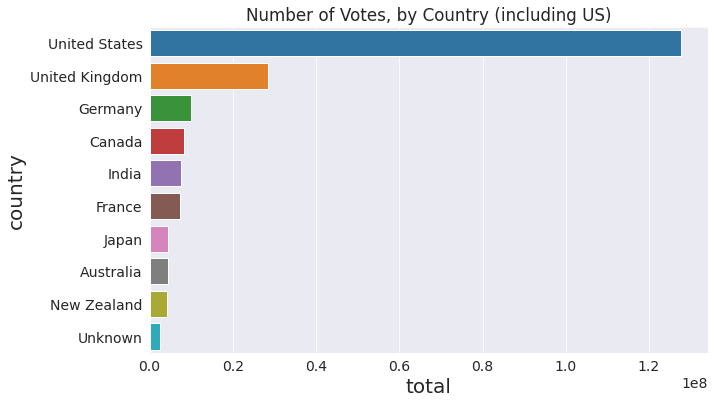

In [39]:
#matplotlib.rcParams['font.size'] = 100

plt.figure(figsize=(10,6))
#plt.xticks(rotation=75)
plt.title('Number of Votes, by Country (including US)')
plt.xlabel('Votes', fontsize=20)
plt.ylabel('Country', fontsize=20)
sns.barplot(x=full_votes_df.total.head(10), y=full_votes_df.country.head(10));

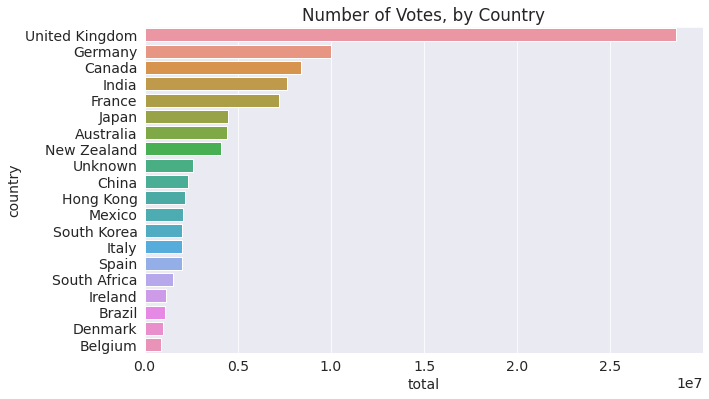

In [38]:
plt.figure(figsize=(10,6))
#plt.xticks(rotation=75)
plt.title('Number of Votes, by Country')
sns.barplot(x=full_votes_df.total.iloc[1:21], y=full_votes_df.country.iloc[1:21]);

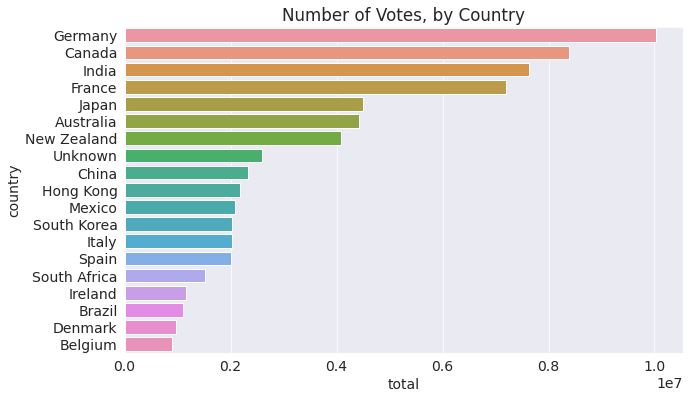

In [37]:
plt.figure(figsize=(10,6))
#plt.xticks(rotation=75)
plt.title('Number of Votes, by Country')
sns.barplot(x=full_votes_df.total.iloc[2:21], y=full_votes_df.country.iloc[2:21]);

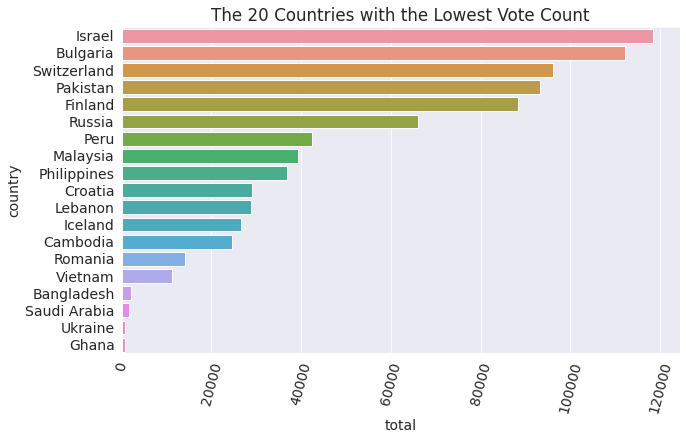

In [36]:
plt.figure(figsize=(10, 6))
plt.xticks(rotation=75)
plt.title('The 20 Countries with the Lowest Vote Count')
sns.barplot(x=full_votes_df.total.iloc[-20:-1], y=full_votes_df.country.iloc[-20:-1]);

### Let's see where the ratings are clustered by plotting value density.

#### All Ratings for United States, United Kingdom and India

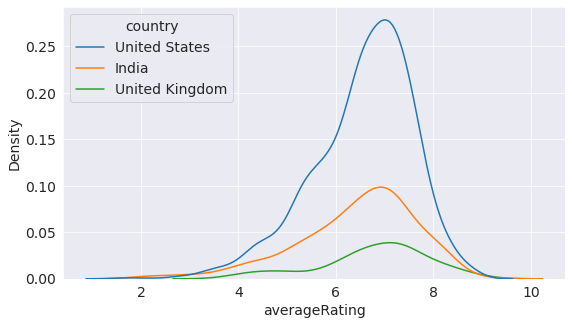

In [40]:
sns.kdeplot(final_df[(final_df.country == 'United States') |
                     (final_df.country == 'United Kingdom') |
                     (final_df.country == 'India')].averageRating,
            hue=final_df[(final_df.country == 'United States') |
                                   (final_df.country == 'United Kingdom') |
                                   (final_df.country == 'India')].country);

## We can draw a custom density plot on the fly using the MultiSelect and Button Widges.  From the list below, pick which countries you would like to include in the plot; choose as many countries as you like!

SelectMultiple(description='Countries', options=('Argentina', 'Australia', 'Austria', 'Bangladesh', 'Belgium',…

Button(description='Plot', style=ButtonStyle())

Output()

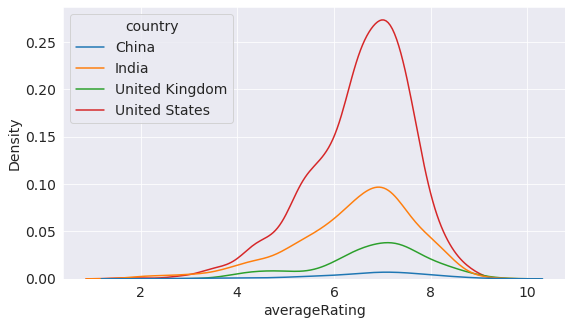

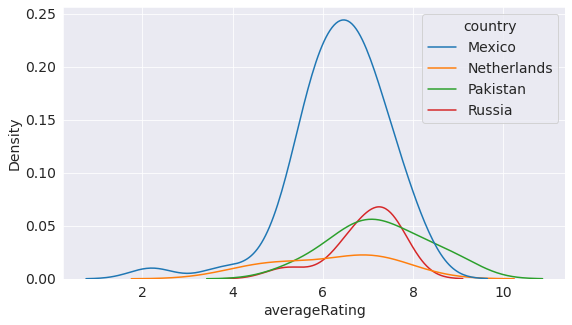

In [44]:
from IPython.display import display

countries = widgets.SelectMultiple(
  options=list(final_df.country[final_df.country_count == 1].sort_values().unique()),
  value=[],
  #rows=10,
  description='Countries',
  disabled=False
  )

bttn = widgets.Button(
  description='Plot',
  disabled=False,
  button_style='', # 'success', 'info', 'warning', 'danger' or ''
  tooltip='Plot',
  icon='check'
  )

display(countries)

button = widgets.Button(description="Plot")
output = widgets.Output()

display(button, output)

def on_button_clicked(b):
  country_density_df = pd.DataFrame()
  for country in countries.value:
    country_density_df = pd.concat([country_density_df, final_df[final_df.country == country]])
  with output:
    sns.kdeplot(country_density_df.averageRating, hue=country_density_df.country);

button.on_click(on_button_clicked)

### These are the ten most commonly used words throughout all of the descriptions, many of them unsurprising.

In [45]:
desc_list = []
for desc in netflix_df.description:
    desc = desc.lower()
    desc_list.append(desc.replace('_', ' ').replace(', ', ' ').replace('.', ' ').replace('-', ' ').split())
    
desc_word_list = []
for desc in desc_list:
    for word in desc:
        desc_word_list.append(word.strip())
        
desc_word_pd = pd.DataFrame(desc_word_list, columns=['word'])
        
desc_words_df = pd.DataFrame(desc_word_list, columns=['word'])
desc_words_grp = pd.DataFrame(desc_words_df.groupby('word')['word'].count())
desc_words_grp = desc_words_grp.rename(columns={'word':'frq'})

top_words = pd.DataFrame(desc_words_grp.frq.sort_values(ascending=False).head(1000), columns=['frq']).reset_index() # reset_index() allows us to create a new index beginning from 0 and, ultimately, more easily drop unneccessary columns

top_words['percentage'] = top_words.frq.map(lambda x: (x / top_words.frq.sum()) * 100)

top_words.head(10)

,word,frq,percentage
0,a,7983,7.669398
1,the,5860,5.629798
2,to,4542,4.363573
3,and,4482,4.305931
4,of,3884,3.731422
5,in,3171,3.046431
6,his,2344,2.251919
7,with,1553,1.491992
8,her,1460,1.402646
9,an,1365,1.311378


### The pie chart below displays the frequency of all words across all descriptions.  It gets far too illegible; let's break it down further, because...

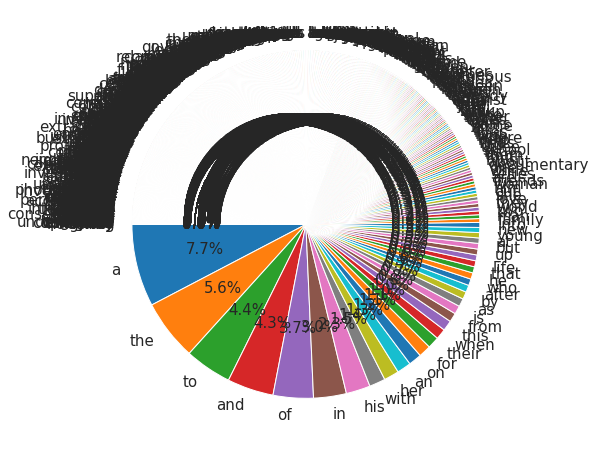

In [46]:
matplotlib.rcParams['font.size'] = 15
plt.figure(figsize=(16, 8))
plt.pie(top_words.frq, labels=top_words.word, autopct='%1.1f%%', startangle=180);

### ...the top ten words alone make up over 35% of the word usage; of that 35%, the word 'a' makes up over a fifth.

In [47]:
top_words.percentage.head(10).sum()

35.2044884666007

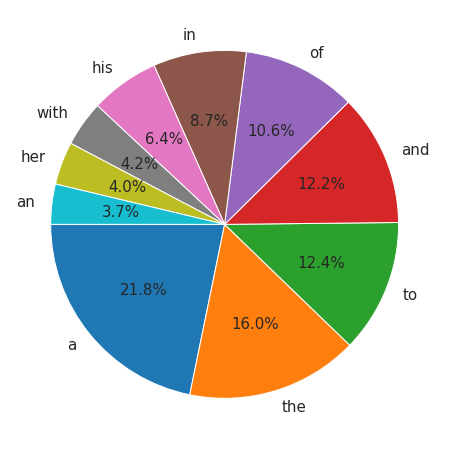

In [48]:
plt.figure(figsize=(16, 8))
plt.fontsize=15
plt.pie(top_words.frq.head(10), labels=top_words.word.head(10), autopct='%1.1f%%', startangle=180);

### Word frequency for US in descending order.

In [49]:
netflix_us_df = netflix_df[netflix_df.country == 'United States']

desc_list2 = []
for desc in netflix_us_df.description:
    desc = desc.lower()
    desc_list2.append(desc.replace('_', ' ').replace(', ', ' ').replace('.', ' ').replace('-', ' ').split())
    
desc_word_list2 = []
for desc in desc_list2:
    for word in desc:
        desc_word_list2.append(word.strip())
        
desc_word_pd2 = pd.DataFrame(desc_word_list2, columns=['word'])
        
desc_words_df2 = pd.DataFrame(desc_word_list2, columns=['word'])
desc_words_grp2 = pd.DataFrame(desc_words_df2.groupby('word')['word'].count())
desc_words_grp2 = desc_words_grp2.rename(columns={'word':'frq'})

top_words_us = pd.DataFrame(desc_words_grp2.frq.sort_values(ascending=False).head(1000), columns=['frq'])
top_words_us = top_words_us.reset_index() # reset_index() allows us to create a new index beginning from 0 and, ultimately, more easily drop unneccessary columns

top_words_us['percentage'] = top_words_us.frq.map(lambda x: (x / top_words_us.frq.sum()) * 100)
top_words_us['country'] = 'United States'

top_words_us

,word,frq,percentage,country
0,a,2293,6.784827,United States
1,the,1945,5.755119,United States
2,and,1553,4.595218,United States
3,to,1356,4.012309,United States
4,of,1264,3.740088,United States
...,...,...,...,...
995,using,7,0.020713,United States
996,boxer,7,0.020713,United States
997,serious,7,0.020713,United States
998,water,7,0.020713,United States


### Word frequency for India, in descending order.

In [50]:
netflix_india_df = netflix_df[netflix_df.country == 'India']

desc_list3 = []
for desc in netflix_india_df.description:
    desc = desc.lower()
    desc_list3.append(desc.replace('_', ' ').replace(', ', ' ').replace('.', ' ').replace('-', ' ').split())
    
desc_word_list3 = []
for desc in desc_list3:
    for word in desc:
        desc_word_list3.append(word.strip())
        
desc_word_pd3 = pd.DataFrame(desc_word_list3, columns=['word'])
        
desc_words_df3 = pd.DataFrame(desc_word_list3, columns=['word'])
desc_words_grp3 = pd.DataFrame(desc_words_df3.groupby('word')['word'].count())
desc_words_grp3 = desc_words_grp3.rename(columns={'word':'frq'})

top_words_india = pd.DataFrame(desc_words_grp3.frq.sort_values(ascending=False).head(1000), columns=['frq'])
top_words_india = top_words_india.reset_index() # reset_index() allows us to create a new index beginning from 0 and, ultimately, more easily drop unneccessary columns

top_words_india['percentage'] = top_words_india.frq.map(lambda x: (x / top_words_us.frq.sum()) * 100)
top_words_india['country'] = 'India'

top_words_india

,word,frq,percentage,country
0,a,1249,3.695704,India
1,to,662,1.958812,India
2,the,634,1.875962,India
3,of,489,1.446917,India
4,and,446,1.319683,India
...,...,...,...,...
995,taxi,3,0.008877,India
996,demands,3,0.008877,India
997,desires,3,0.008877,India
998,twins,3,0.008877,India


### Word frequency for UK, in descending order.

In [51]:
netflix_uk_df = netflix_df[netflix_df.country == 'United Kingdom']

desc_list4 = []
for desc in netflix_uk_df.description:
    desc = desc.lower()
    desc_list4.append(desc.replace('_', ' ').replace(', ', ' ').replace('.', ' ').replace('-', ' ').split())
    
desc_word_list4 = []
for desc in desc_list4:
    for word in desc:
        desc_word_list4.append(word.strip())
        
desc_word_pd4 = pd.DataFrame(desc_word_list4, columns=['word'])
        
desc_words_df4 = pd.DataFrame(desc_word_list4, columns=['word'])
desc_words_grp4 = pd.DataFrame(desc_words_df4.groupby('word')['word'].count())
desc_words_grp4 = desc_words_grp4.rename(columns={'word':'frq'})

top_words_uk = pd.DataFrame(desc_words_grp4.frq.sort_values(ascending=False).head(1000), columns=['frq'])
top_words_uk = top_words_uk.reset_index() # reset_index() allows us to create a new index beginning from 0 and, ultimately, more easily drop unneccessary columns

top_words_uk['percentage'] = top_words_uk.frq.map(lambda x: (x / top_words_us.frq.sum()) * 100)
top_words_uk['country'] = 'United Kingdom'

top_words_uk

,word,frq,percentage,country
0,the,396,1.171736,United Kingdom
1,a,315,0.932063,United Kingdom
2,and,275,0.813706,United Kingdom
3,of,245,0.724938,United Kingdom
4,to,199,0.588827,United Kingdom
...,...,...,...,...
995,educator,1,0.002959,United Kingdom
996,gromit,1,0.002959,United Kingdom
997,electronic,1,0.002959,United Kingdom
998,elements,1,0.002959,United Kingdom


### The top five words for all three countries are identical, except for their position on the list.

### Now let's look at some of the least common words.

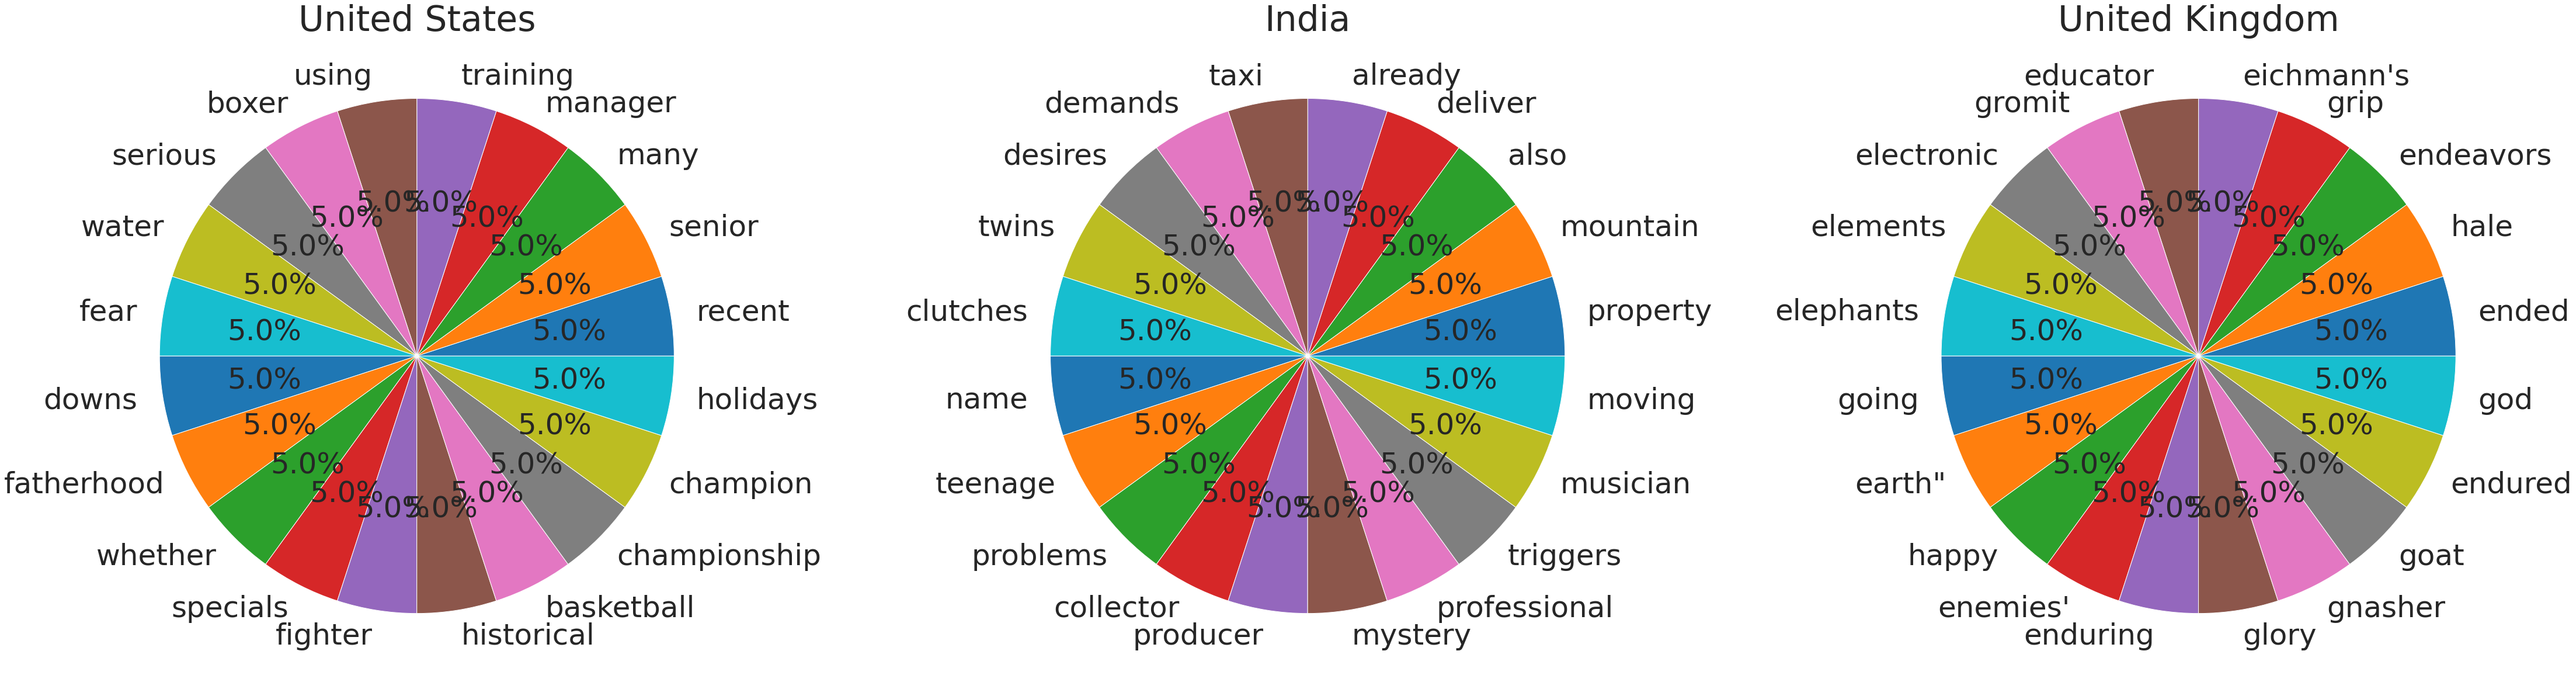

In [52]:
fig, axes = plt.subplots(1, 3, figsize=(64, 32))
matplotlib.rcParams['font.size'] = 50
axes[0].pie(top_words_us.frq.tail(20), labels=top_words_us.word.tail(20), autopct='%1.1f%%', startangle=180);
axes[0].set_title('United States')
axes[1].pie(top_words_india.frq.tail(20), labels=top_words_india.word.tail(20), autopct='%1.1f%%', startangle=180);
axes[1].set_title('India')
axes[2].pie(top_words_uk.frq.tail(20), labels=top_words_uk.word.tail(20), autopct='%1.1f%%', startangle=180);
axes[2].set_title('United Kingdom')

plt.tight_layout(pad=2);

### The above pie charts show 20 of the least common descriptive words for US, India and UK.

### Below is a scatterplot of 'averageRating' VS 'numVotes'.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


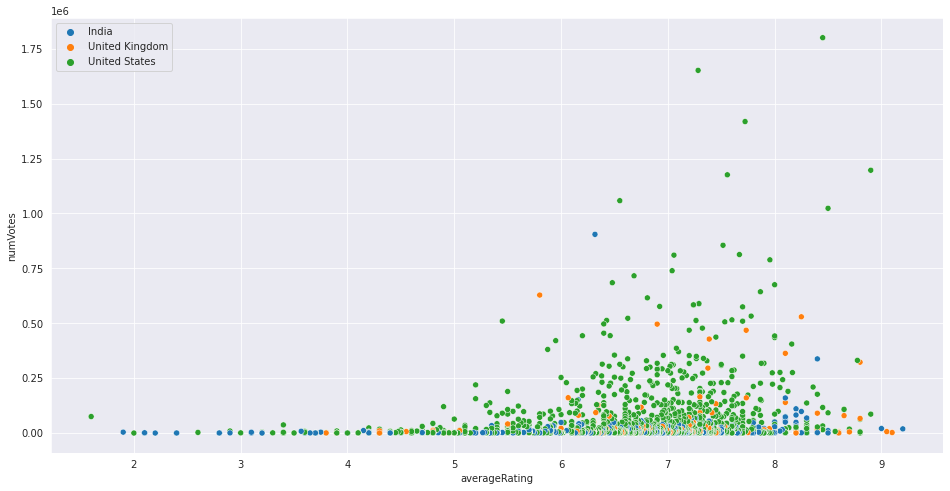

In [53]:
matplotlib.rcParams['font.size'] = 10
plt.figure(figsize=(16,8))
sns.scatterplot(final_df[(final_df.country == 'United States') |
                         (final_df.country == 'United Kingdom') |
                         (final_df.country == 'India')].sort_values('averageRating', ascending=False).averageRating, final_df[(final_df.country == 'United States') |
                         (final_df.country == 'United Kingdom') |
                         (final_df.country == 'India')].sort_values('averageRating', ascending=False).numVotes, hue=final_df[(final_df.country == 'United States') |
                         (final_df.country == 'United Kingdom') |
                         (final_df.country == 'India')].sort_values('averageRating', ascending=False).country.tolist());

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


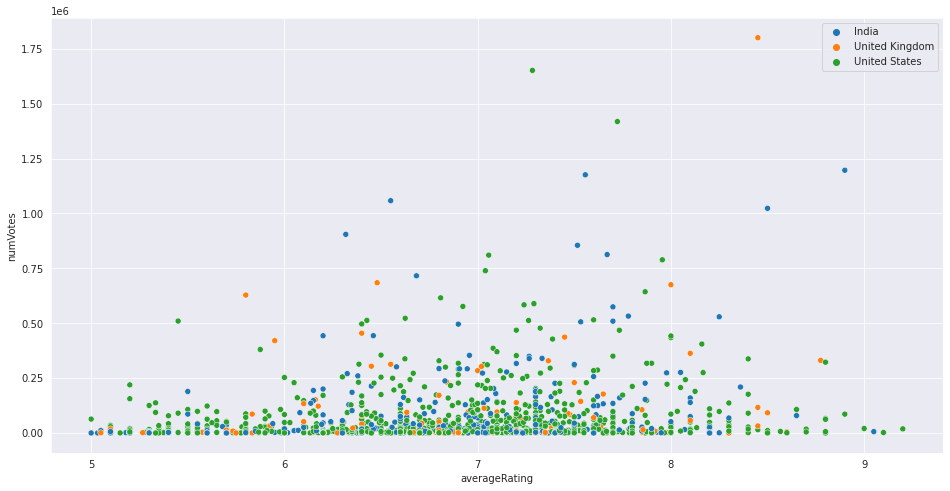

In [54]:
matplotlib.rcParams['font.size'] = 10
plt.figure(figsize=(16,8))
sns.scatterplot(final_df[(final_df.averageRating >= 5) & ((final_df.country == 'United States') |
                         (final_df.country == 'United Kingdom') |
                         (final_df.country == 'India'))].sort_values('averageRating', ascending=False).averageRating, final_df[(final_df.country == 'United States') |
                         (final_df.country == 'United Kingdom') |
                         (final_df.country == 'India')].sort_values('averageRating', ascending=False).numVotes, hue=final_df[(final_df.country == 'United States') |
                         (final_df.country == 'United Kingdom') |
                         (final_df.country == 'India')].sort_values('averageRating', ascending=False).country.tolist());

## Asking and Answering Questions

### Explore differences between, as well as similarities among, content available in different countries

### Question 1: What are the least common words used in description?

In [59]:
desc_list = []
for desc in netflix_df.description:
    desc = desc.lower()
    desc_list.append(desc.replace('_', ' ').replace(', ', ' ').replace('.', ' ').replace('-', ' ').split())
    
desc_word_list = []
for desc in desc_list:
    for word in desc:
        desc_word_list.append(word.strip())
        
desc_word_pd = pd.DataFrame(desc_word_list, columns=['word'])
        
desc_words_df = pd.DataFrame(desc_word_list, columns=['word'])
desc_words_grp = pd.DataFrame(desc_words_df.groupby('word')['word'].count())
desc_words_grp = desc_words_grp.rename(columns={'word':'frq'})

top_words = pd.DataFrame(desc_words_grp.frq.sort_values(ascending=False), columns=['frq']).reset_index() # reset_index() allows us to create a new index beginning from 0 and, ultimately, more easily drop unneccessary columns

top_words['percentage'] = top_words.frq.map(lambda x: (x / top_words.frq.sum()) * 100)

In [60]:
uc_words = top_words.tail(10)[['word', 'frq', 'percentage']].reset_index().drop('index', axis=1)
uc_words.sort_values('frq', ascending=False)

,word,frq,percentage
0,kimchee,1,0.000662
1,kingdom!,1,0.000662
2,underlying,1,0.000662
3,undermined,1,0.000662
4,kinetics,1,0.000662
5,kindai,1,0.000662
6,underperforming,1,0.000662
7,kin,1,0.000662
8,kimmy,1,0.000662
9,…,1,0.000662


### Here we have the 10 least commonly occurring words in the descriptions.

### Question 2: Which country consistently gives the highest ratings?

In [61]:
us_ratings = final_df[final_df.country == 'United States'].averageRating
uk_ratings = final_df[final_df.country == 'United Kingdom'].averageRating
india_ratings = final_df[final_df.country == 'India'].averageRating

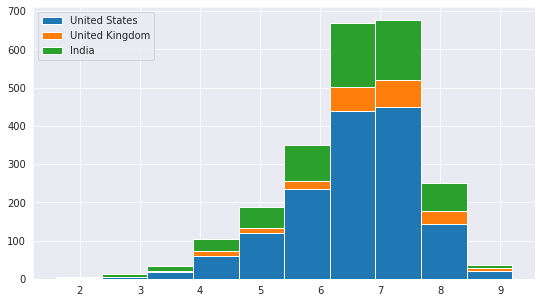

In [62]:
plt.hist([us_ratings, uk_ratings, india_ratings], 
         stacked=True);
plt.legend(['United States', 'United Kingdom', 'India']);

### Question 3: Because India consistently gives the highest ratings to its available content, which type of content is preferred in India: Movie or TV Show?

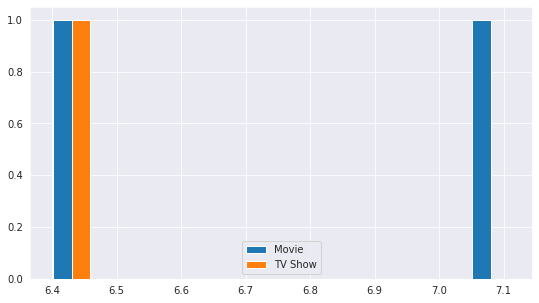

In [63]:
india_rating_tv = final_df[(final_df.country == 'India')].groupby('type')['averageRating'].mean()
india_rating_movie = final_df[(final_df.country == 'India') & (final_df.type == 'Movie')]['averageRating'].mean()

plt.hist([india_rating_tv, india_rating_movie]);

plt.legend(['Movie', 'TV Show']);

### It appears that India, as a country, prefers the TV Shows on Netflix over the Movies.

### Question 4: Does Netflix availability follow the Pareto Distribution?

### For the Pareto Distribution to hold for overall access to content by country, the top 20% of the countries in the list of content amount should account for 80% of the overall usage.  Let's see if this is the case.

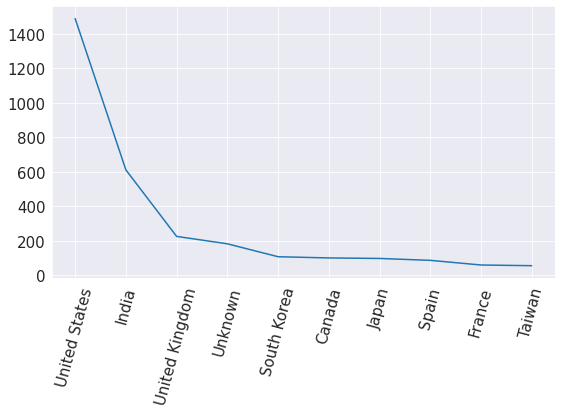

In [64]:
matplotlib.rcParams['font.size'] = 15

xplt = final_df.groupby('country').count().sort_values('title', ascending=False).reset_index().country.head(10)
yplt = final_df.groupby('country').count().sort_values('title', ascending=False).reset_index().title.head(10)
plt.xticks(rotation=75)
plt.plot(xplt, yplt)

### This graph closely mirrors a Pareto Distribution.

## Inferences and Conclusion

### There are obviously many interrelations between the data in this set, however, it appears that a prime takeaway is that TV Shows are valued more than movies in today's world;  in addition, it appears that India is a fast growing market which uses the rating system more favorably than some other, Western countries.

## References and Future Work

* https://www.kaggle.com/shivamb/netflix-shows
* https://datasets.imdbws.com/

* There should be more care taken when comparing titles by country.  There are a number of titles which are available in multiple countries and these combinations are counted as their own 'country'.

In [65]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.utils.colab.set_colab_file_id('1T6KgDWEX7GsKq5Z-61IeuE_3sfj52jgQ')

     |████████████████████████████████| 71kB 2.9MB/s 


In [67]:
jovian.commit(project="Netflix-Data-Analysis")

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/jandrewtomich/netflix-data-analysis


'https://jovian.ai/jandrewtomich/netflix-data-analysis'